In [51]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.io import fits
from lsst.sims.selfcal.analysis.healplots import healbin
import healpy as hp

In [3]:
hdulist = fits.open('ut012716.0100.long.M.fits')

In [5]:
image = hdulist[0].data

In [6]:
image

array([[2038, 2036, 2051, ..., 2040, 2048, 2054],
       [2059, 2055, 2040, ..., 2054, 2054, 2048],
       [2036, 2049, 2042, ..., 2041, 2056, 2054],
       ..., 
       [2041, 2044, 2051, ..., 2049, 2048, 2050],
       [2044, 2043, 2041, ..., 2052, 2045, 2051],
       [2041, 2041, 2042, ..., 2037, 2046, 2071]], dtype=int16)

In [42]:
coords = np.genfromtxt('ut012716.0100.long.M.xxyy', dtype=[int,int,float,float])

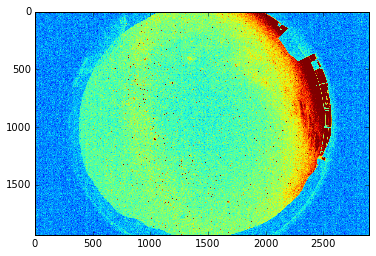

In [15]:
plt.imshow(image, vmin=image.min(), vmax=image.min()+100)
#plt.figure()
#ax = plt.subplot(111, projection = 'mollweide')
#ax.plot(coords[:,2],coords[:,3])

In [17]:
print image.shape, coords.shape


 (1935, 2897) (5600864, 4)


In [20]:
coords[:,0].size

5600864

In [49]:
healMap = healbin(np.radians(coords['f2']), np.radians(coords['f3']), image[coords['f1'],coords['f0'] ] )

/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


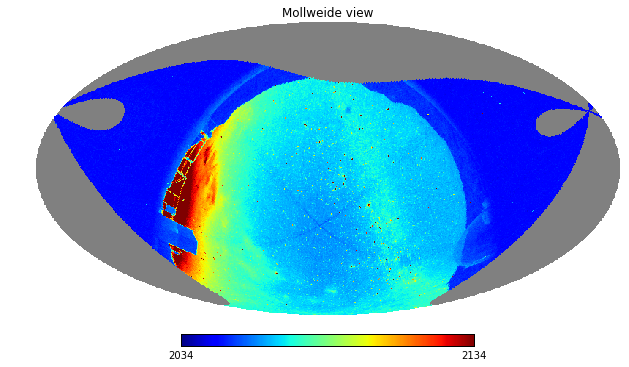

In [58]:
hp.mollview(healMap, max=2134)